In [ ]:
"""
Regression CheatSheet with SHAP integrated - SHAP_integrated.ipynb
Author: Aditya Bhatt
Date: 2024-06-15

Quick repo starter file for your Regression CheatSheet repo.
Includes runnable examples (using sklearn.datasets.load_diabetes by default),
and functions for:
 - Linear, Ridge, Lasso, ElasticNet
 - Polynomial (pipeline)
 - SVR
 - DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor
 - Pipeline example (StandardScaler + Ridge)
 - Optional placeholders for XGBoost/LightGBM (commented)

Requirements (minimal):
 numpy, pandas, scikit-learn, matplotlib (optional)
 Optional: xgboost, lightgbm (commented)
"""

'\nRegression CheatSheet with SHAP integrated - SHAP_integrated.py\nAuthor: Aditya Bhatt\nDate: 2024-06-15\n\nQuick repo starter file for your Regression CheatSheet repo.\nIncludes runnable examples (using sklearn.datasets.load_diabetes by default),\nand functions for:\n - Linear, Ridge, Lasso, ElasticNet\n - Polynomial (pipeline)\n - SVR\n - DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor\n - Pipeline example (StandardScaler + Ridge)\n - Optional placeholders for XGBoost/LightGBM (commented)\n\nRequirements (minimal):\n numpy, pandas, scikit-learn, matplotlib (optional)\n Optional: xgboost, lightgbm (commented)\n'

In [9]:
!pip install --upgrade -r requirements.txt -qq

In [10]:
# Imports
import warnings
warnings.filterwarnings("ignore")

import os
import argparse
from typing import Tuple, Dict

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Regression models / tools
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb

In [ ]:
# ---------- Utilities ----------

def load_data(dataset: str = "diabetes", test_size: float = 0.2, random_state: int = 42
             ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Load dataset and split.
    dataset: 'diabetes' or 'custom dataset' (expects data/filename.csv with say 4 columns)
    returns: X_train, X_test, y_train, y_test
    """
    if dataset == "house":
        path = os.path.join("data", "filename.csv")
        if not os.path.exists(path):
            raise FileNotFoundError(f"{path} not found. Place your CSV at this path or use --data diabetes")
        df = pd.read_csv(path)
        X = df[["column1", "column2", "column3"]].values
        y = df["column4"].values
    else:
        from sklearn.datasets import load_diabetes
        data = load_diabetes()
        X = data["data"]
        y = data["target"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test


def print_regression_metrics(y_true: np.ndarray, y_pred: np.ndarray, name: str = None) -> Dict[str, float]:
    """Compute and print R2, MSE, MAE. Returns a dict of metrics."""
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    if name:
        print(f"[{name}] R2: {r2:.4f} | MSE: {mse:.4f} | MAE: {mae:.4f}")
    else:
        print(f"R2: {r2:.4f} | MSE: {mse:.4f} | MAE: {mae:.4f}")
    return {"r2": r2, "mse": mse, "mae": mae}


In [12]:
# ---------- SHAP helper (replacement) ----------
def shap_summary(model, X_train, X_test, model_name="Model", max_display=8, kernel_bg_size=50):
    """
    Robust SHAP summary helper.
    - Prefers TreeExplainer for tree models (fast).
    - For Pipelines / sklearn models: uses model.predict as callable with shap.Explainer.
    - For non-tree blackbox models (SVR, MLP, etc): uses shap.KernelExplainer on a small background sample.
    - Shows beeswarm in notebooks; otherwise prints top features by mean |SHAP|.
    - kernel_bg_size: number of background samples used for KernelExplainer (keep small).
    """
    try:
        import shap
    except ModuleNotFoundError:
        print(f"[SHAP] shap not installed; skipping SHAP for {model_name}")
        return
    except Exception as e:
        print(f"[SHAP] unexpected import error for shap: {e}; skipping SHAP for {model_name}")
        return

    # Prepare a callable predictor and feature names
    # If model is a Pipeline or any object with predict, use model.predict as callable
    if hasattr(model, "predict"):
        predict_fn = lambda X: np.array(model.predict(X))
    else:
        # last resort: try to use the model itself if callable
        if callable(model):
            predict_fn = model
        else:
            print(f"[SHAP] model for {model_name} is not callable and has no .predict; skipping")
            return

    # Get feature names if available (shap likes named features)
    feat_names = None
    try:
        # X_train may be numpy or pandas DataFrame
        if hasattr(X_train, "columns"):
            feat_names = list(X_train.columns)
        elif hasattr(X_train, "shape"):
            feat_names = [f"f{i}" for i in range(X_train.shape[1])]
    except Exception:
        feat_names = None

    # Try TreeExplainer first for tree-based models
    try:
        # Many tree models are instances of sklearn/ensemble or xgboost/lgb/catboost.
        explainer = None
        # prefer TreeExplainer for known tree objects
        try:
            explainer = shap.TreeExplainer(model)
        except Exception:
            # try generic Explainer with the predict function and a masker
            try:
                # shap.maskers.Independent is a robust default
                masker = shap.maskers.Independent(X_train if hasattr(X_train, "shape") else np.array(X_train))
                explainer = shap.Explainer(predict_fn, masker, feature_names=feat_names)
            except Exception:
                explainer = None

        if explainer is None:
            raise RuntimeError("no explainer created in TreeExplainer branch")

        shap_values = explainer(X_test)
    except Exception as e_tree:
        # TreeExplainer path failed — fallback to KernelExplainer for black-box models (SVR, MLP etc).
        # KernelExplainer is slower — use a small background sample.
        try:
            # create a small background dataset for kernel explainer
            import numpy as _np
            idx = _np.random.choice(range(X_train.shape[0]), min(kernel_bg_size, X_train.shape[0]), replace=False)
            background = X_train[idx] if hasattr(X_train, "__getitem__") else X_train[idx, :]
            # KernelExplainer requires a 1D output function; ensure predict_fn returns 1D
            ke = shap.KernelExplainer(predict_fn, background, link="identity")
            shap_values = ke.shap_values(X_test, nsamples=min(200, max(50, int(0.2 * X_train.shape[0]))))
        except Exception as e_kernel:
            print(f"[SHAP] could not create explainer for {model_name}: Tree error: {e_tree}; Kernel error: {e_kernel}; skipping")
            return

    # At this point shap_values is available — try plotting or fallback to textual summary
    try:
        # shap.plots.beeswarm works if shap_values is a single-array or list; handle both
        shap.plots.beeswarm(shap_values, max_display=max_display)
        print(f"[SHAP] beeswarm plotted for {model_name}")
        return
    except Exception:
        pass

    # Fallback text summary: show top features by mean absolute SHAP
    try:
        import numpy as _np
        if hasattr(shap_values, "values"):
            vals = shap_values.values
        else:
            vals = shap_values
        arr = _np.array(vals)
        # if arr is list of arrays (multiclass), try to average
        if isinstance(arr, list):
            arr = _np.array(arr)
            if arr.ndim == 3:
                arr = arr.mean(axis=0)
        if arr.ndim == 3:  # (samples, outputs, features) -> average outputs
            arr = arr.mean(axis=1)
        mean_abs = _np.mean(_np.abs(arr), axis=0)
        top_idx = _np.argsort(mean_abs)[::-1]
        print(f"[SHAP] top features by mean |SHAP| for {model_name}:")
        for i in top_idx[:min(len(top_idx), max_display)]:
            name = feat_names[i] if feat_names is not None else f"f{i}"
            print(f"  {name}: {mean_abs[i]:.6f}")
    except Exception as e:
        print(f"[SHAP] textual fallback failed for {model_name}: {e}")


In [13]:
# ---------- Models & examples ----------

def train_and_eval_linear(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    res = print_regression_metrics(y_test, y_pred, "LinearRegression")
    shap_summary(model, X_train, X_test, "LinearRegression")
    return res


def train_and_eval_ridge_lasso_enet(X_train, X_test, y_train, y_test):
    results = {}
    ridge = Ridge(alpha=1.0, random_state=42).fit(X_train, y_train)
    results["ridge"] = print_regression_metrics(y_test, ridge.predict(X_test), "Ridge")
    shap_summary(ridge, X_train, X_test, "Ridge")

    lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000).fit(X_train, y_train)
    results["lasso"] = print_regression_metrics(y_test, lasso.predict(X_test), "Lasso")
    shap_summary(lasso, X_train, X_test, "Lasso")

    enet = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000).fit(X_train, y_train)
    results["elasticnet"] = print_regression_metrics(y_test, enet.predict(X_test), "ElasticNet")
    shap_summary(enet, X_train, X_test, "ElasticNet")

    return results


def train_and_eval_polynomial(X_train, X_test, y_train, y_test, degree: int = 3):
    pipe = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
            ("scale", StandardScaler(with_mean=False)),
            ("lin", Ridge(alpha=1.0)),
        ]
    )
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    res = print_regression_metrics(y_test, y_pred, f"Polynomial(deg={degree})")
    shap_summary(pipe, X_train, X_test, f"Polynomial(deg={degree})")
    return res


def train_and_eval_svr(X_train, X_test, y_train, y_test):
    svr = SVR(kernel="rbf", C=1.0, epsilon=0.1).fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    res = print_regression_metrics(y_test, y_pred, "SVR")
    shap_summary(svr, X_train, X_test, "SVR")
    return res


def train_and_eval_tree_ensembles(X_train, X_test, y_train, y_test):
    results = {}
    dt = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
    results["dt"] = print_regression_metrics(y_test, dt.predict(X_test), "DecisionTree")
    shap_summary(dt, X_train, X_test, "DecisionTree")

    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train, y_train)
    results["rf"] = print_regression_metrics(y_test, rf.predict(X_test), "RandomForest")
    shap_summary(rf, X_train, X_test, "RandomForest")

    gbr = GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, max_depth=3, random_state=42).fit(
        X_train, y_train
    )
    results["gbr"] = print_regression_metrics(y_test, gbr.predict(X_test), "GradientBoosting")
    shap_summary(gbr, X_train, X_test, "GradientBoosting")

    return results


def train_and_eval_xgboost(X_train, X_test, y_train, y_test):
    xg = xgb.XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1).fit(X_train, y_train)
    res = print_regression_metrics(y_test, xg.predict(X_test), "XGBoost")
    shap_summary(xg, X_train, X_test, "XGBoost")
    return res

def pipeline_ridge(X_train, X_test, y_train, y_test):
    pipe = Pipeline([("scale", StandardScaler()), ("ridge", Ridge(alpha=1.0))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    res = print_regression_metrics(y_test, y_pred, "Pipeline-Ridge")
    shap_summary(pipe, X_train, X_test, "Pipeline-Ridge")
    return res



=== Regression CheatSheet Demo (dataset: diabetes) ===
[LinearRegression] R2: 0.4526 | MSE: 2900.1936 | MAE: 42.7941


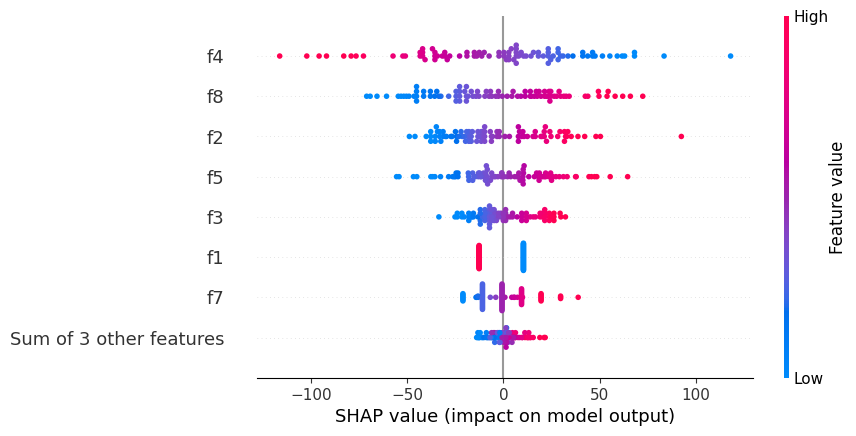

[SHAP] beeswarm plotted for LinearRegression
[Ridge] R2: 0.4192 | MSE: 3077.4159 | MAE: 46.1389


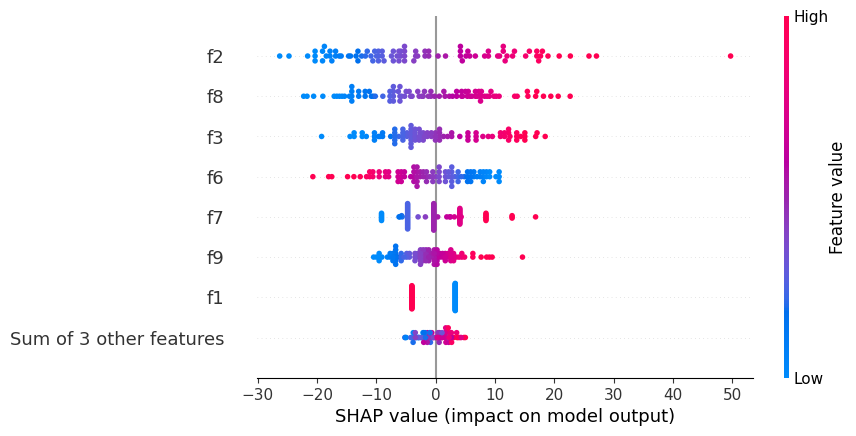

[SHAP] beeswarm plotted for Ridge
[Lasso] R2: 0.4567 | MSE: 2878.5594 | MAE: 42.8318


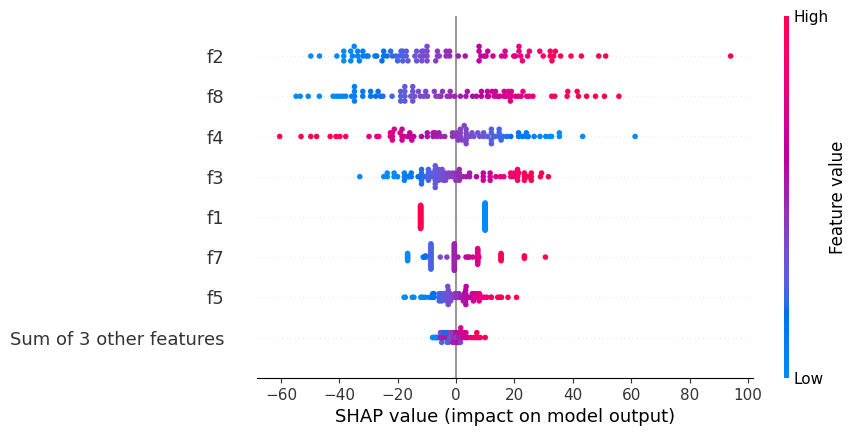

[SHAP] beeswarm plotted for Lasso
[ElasticNet] R2: 0.3736 | MSE: 3318.5057 | MAE: 48.3961


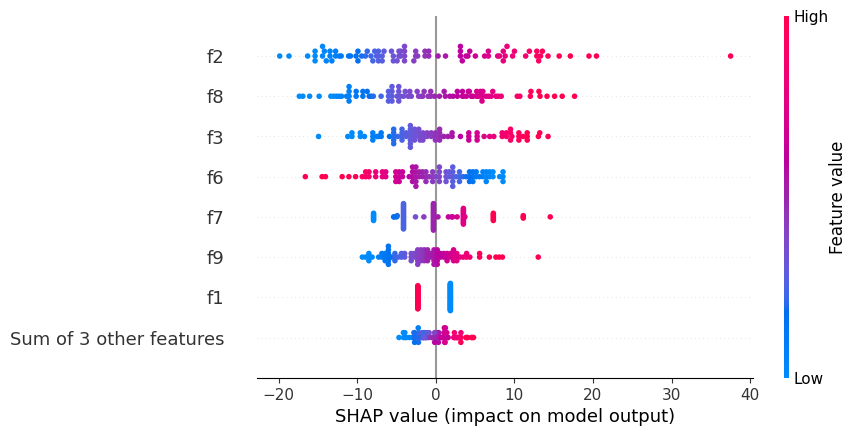

[SHAP] beeswarm plotted for ElasticNet
[Polynomial(deg=2)] R2: 0.4558 | MSE: 2883.3630 | MAE: 41.7144


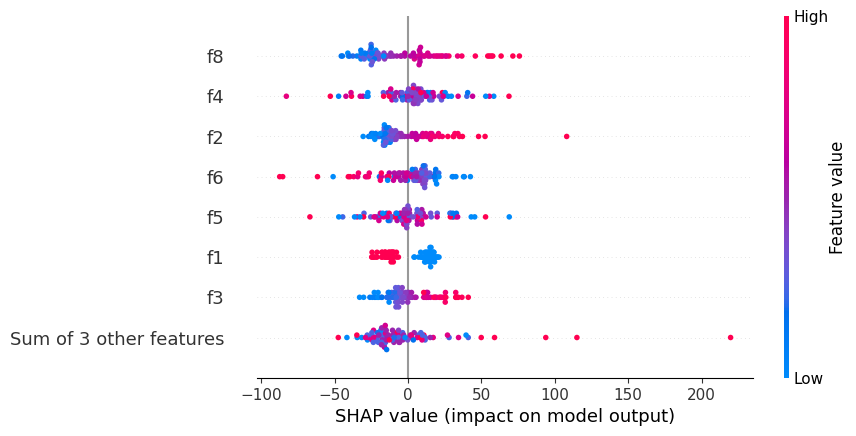

[SHAP] beeswarm plotted for Polynomial(deg=2)
[SVR] R2: 0.1821 | MSE: 4333.2860 | MAE: 56.0237


ExactExplainer explainer: 90it [01:40,  1.23s/it]                        


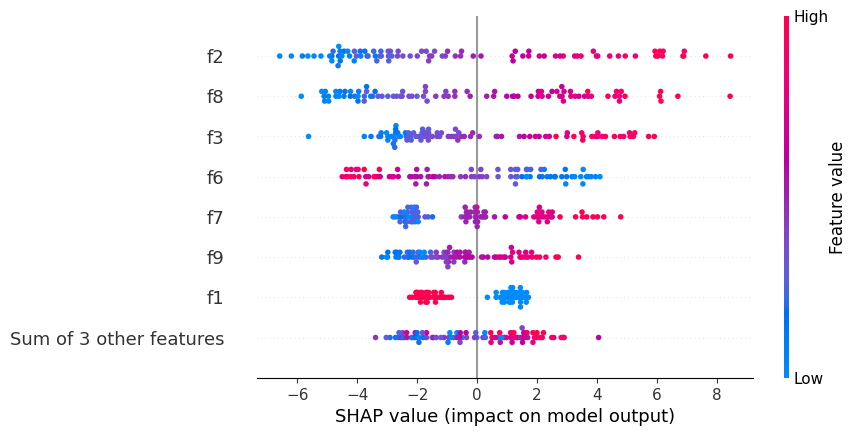

[SHAP] beeswarm plotted for SVR
[DecisionTree] R2: 0.0607 | MSE: 4976.7978 | MAE: 54.5281


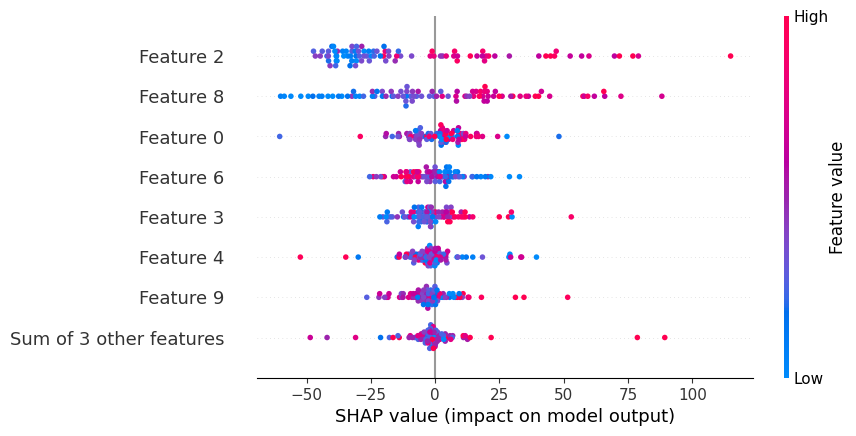

[SHAP] beeswarm plotted for DecisionTree
[RandomForest] R2: 0.4428 | MSE: 2952.0106 | MAE: 44.0530


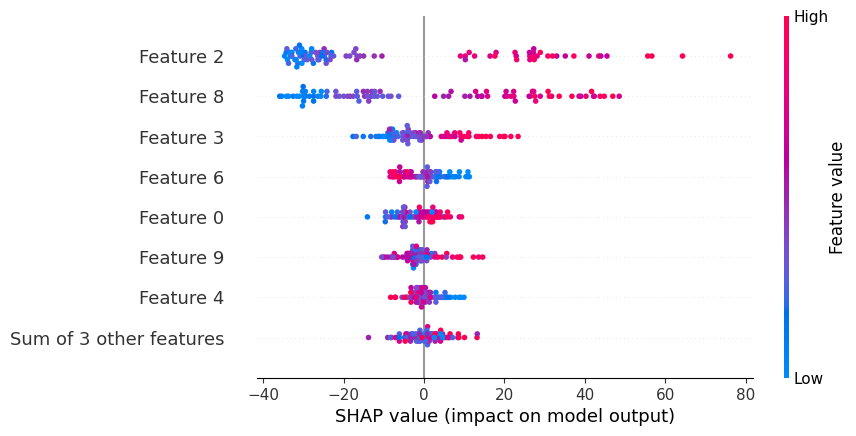

[SHAP] beeswarm plotted for RandomForest
[GradientBoosting] R2: 0.4661 | MSE: 2828.5135 | MAE: 43.4206


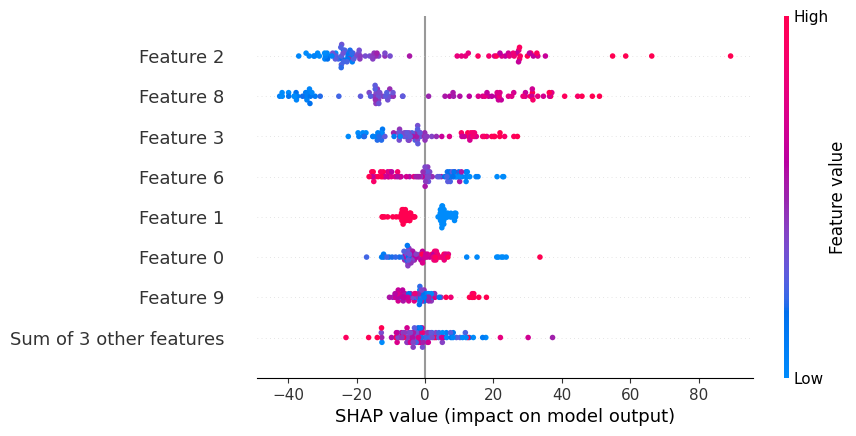

[SHAP] beeswarm plotted for GradientBoosting
[XGBoost] R2: 0.3675 | MSE: 3350.8237 | MAE: 46.3867


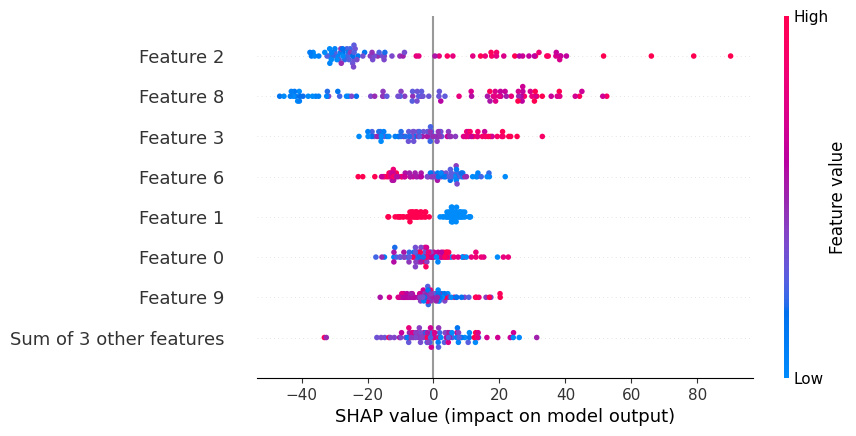

[SHAP] beeswarm plotted for XGBoost
[Pipeline-Ridge] R2: 0.4541 | MSE: 2892.0146 | MAE: 42.8120


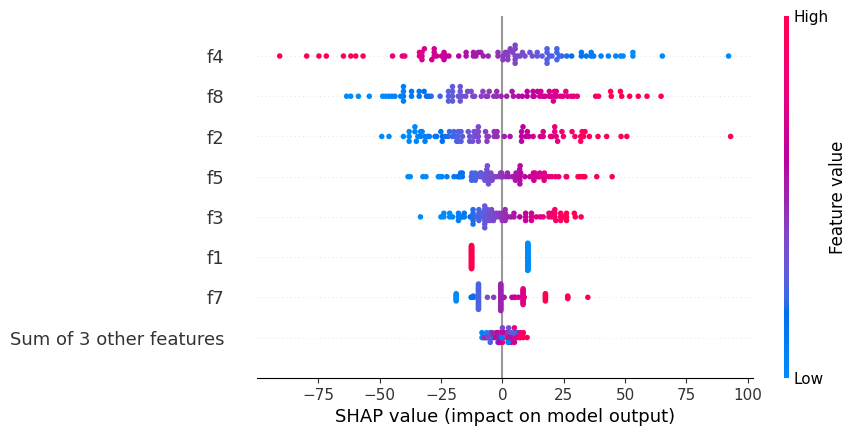

[SHAP] beeswarm plotted for Pipeline-Ridge


In [14]:
# ---------- Demo runner ----------

def run_all(dataset: str = "diabetes"):
    X_train, X_test, y_train, y_test = load_data(dataset=dataset)
    print("\n=== Regression CheatSheet Demo (dataset: {}) ===".format(dataset))
    train_and_eval_linear(X_train, X_test, y_train, y_test)
    train_and_eval_ridge_lasso_enet(X_train, X_test, y_train, y_test)
    train_and_eval_polynomial(X_train, X_test, y_train, y_test, degree=2)
    train_and_eval_svr(X_train, X_test, y_train, y_test)
    train_and_eval_tree_ensembles(X_train, X_test, y_train, y_test)
    train_and_eval_xgboost(X_train, X_test, y_train, y_test)
    pipeline_ridge(X_train, X_test, y_train, y_test)
    
if __name__ == "__main__":
    run_all()
